Importing the used Modules

In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time

#1. the Data

In this part we have look at the data and preprocess it, so that our neural Network can fully understand it.

#1.1 Loading and Splitting

In this part we import the Data and Split it into the requested pieces.

In [2]:
train_data, test_data = tfds.load(
    name="genomics_ood",                    # name of the ds
    split=['train[:100000]','test[:1000]'], # requested train-test-splits. This takes the first 100 000 of the training data and the first 1000 of the test-data
    as_supervised=True)                     # imports the labels as Tupels: (Input, Label)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


Let's take a look at the first element and how it looks

In [3]:
for elem in train_data.take(1):
  print(elem[0])
  print(elem[1])

tf.Tensor(b'AAACTATGTTATATTCACGATGATTAACTTACAAAGGAGTTTCAACTATGAAGATGATAAACAAATTAATCGTTCCGGTAACAGCTAGTGCTTTATTATTAGGCGCTTGTGGCGCTAGTGCCACAGACTCTAAAGAAAATACATTAATTTCTTCTAAAGCTGGAGACGTAACAGTTGCAGATACAATGAAAAAAATCGGTAAAGATCAAATTGCAAATGCATCATTTACTGAAATGTTAAATAAAATTTT', shape=(), dtype=string)
tf.Tensor(7, shape=(), dtype=int64)


##1.2 Transforming the Tensor

Because the sequences are string tensors, we cannot
simply call tf.one hot(x,4) on them. Therefore we need a function which converts the string tensor into a usable tensor that contains the one-hot-encoded sequence. 

We also apply one-hot-encoding on the labels. 

In [4]:
def onehotify(tensor):
  """onehotify(tensor) transforms genomic sequences formerly saved as string tensor into one hot encodinged vectors of those tensors
  """

  #replace the characters with the numbers from 0 to three
  vocab = {"A":"1", "C": "2", "G":"3", "T":"0"} 
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  
  #Next we split after every number and cast the characters to numbers
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)

  #next we compute the one_hot encodings and reshape it
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot

This next block of code describes the process of splitting the dataset creating the one hot vectors and

In [5]:
#since we imported our sequenzes and labels as tupel and later have to work with them seperably we did split them up this way. 
#We thought about different ways of doing this, but could not come up with an easier way to split them up.
#Warning: It is not realy fast, but it works!
train_data_seq = [x for (x,y) in train_data]
train_data_labels = [y for (x,y) in train_data]

test_data_seq = [x for (x,y) in test_data]
test_data_labels = [y for (x,y) in test_data]




#We now create new tensors from the arrays above and create the one-hot encoded versions. 
#we repeat this process for every array of the above

#training data
train_data_seq = tf.data.Dataset.from_tensor_slices(train_data_seq)       
train_data_seq = train_data_seq.map(lambda seq:onehotify(seq))           
train_data_labels = tf.data.Dataset.from_tensor_slices(train_data_labels) 
train_data_labels = train_data_labels.map(lambda t:tf.one_hot(t,10))
#testing data
test_data_seq = tf.data.Dataset.from_tensor_slices(test_data_seq)
test_data_seq = test_data_seq.map(lambda seq:onehotify(seq))
test_data_labels = tf.data.Dataset.from_tensor_slices(test_data_labels)
test_data_labels = test_data_labels.map(lambda t:tf.one_hot(t,10))


#We now zip,batch and shuffle the training/testing dataset
train_dataset = tf.data.Dataset.zip((train_data_seq, train_data_labels))
train_dataset = train_dataset.batch(1000)
train_dataset = train_dataset.shuffle(buffer_size = 128)

test_dataset = tf.data.Dataset.zip((test_data_seq, test_data_labels))
test_dataset = test_dataset.batch(1000)
test_dataset = test_dataset.shuffle(buffer_size = 128)

#2. Model

This model has:

*   Hidden layer 1: 256 units. With sigmoid activation function.
*   Hidden layer 2: 256 units. With sigmoid activation function.
*   Output: 10 units. With softmax activation function.




Output: 10 units. With softmax activation function.



In [6]:
#Implemention of a simple fully connected feed forward neural network.

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.hidden_layer_1 = tf.keras.layers.Dense(
                                                units=256,                              #256 units. With sigmoid activation function.
                                                activation=tf.keras.activations.sigmoid #Sigmoid as activation function
                                                )
        self.hidden_layer_2 = tf.keras.layers.Dense(
                                                units=256,                              #256 units. With sigmoid activation function.
                                                activation=tf.keras.activations.sigmoid #Sigmoid as activation function
                                                )
        self.output_layer = tf.keras.layers.Dense(
                                                units=10,                               #10 units 
                                                activation=tf.keras.activations.softmax #Softmax as activation function
                                                )
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)  #usig the output of the last layer as input of the next.
        x = self.output_layer(x)    #usig the output of the last layer as input of the next.
        return x

#3. Training

Here are some general parameters, that we will need for the training.

In [7]:
#General Parameters
trainforNepochs=10                                      
learning_rate=0.1                                       
running_average_factor = 0.95                           
lossfunction= tf.keras.losses.CategoricalCrossentropy() #we use categorical cross entropy as lossfunction
optimizer = tf.keras.optimizers.SGD(learning_rate)      #we use SGD as optimizer

model = Model()                                         #As model we want to use the model from above

To train our model we first have to define our train step and our test

In [8]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape: #we safe the loss in the gradient tape 
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  


Since we want to visualize them later, we start collectiong data on accuracy and loss for training and test-data.

In [9]:
# Initialize lists for later visualization.
train_losses = []
test_losses = []
test_accuracies = []

#testing once before we begin, so that be have the first datapoints
test_loss, test_accuracy = test(model, test_dataset, lossfunction)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin, so that we have a baseline
train_loss, _ = test(model, train_dataset, lossfunction)
train_losses.append(train_loss)

Now we actually start training the Model

In [10]:
# We train for trainforNepochs epochs.
for epoch in range(trainforNepochs):

    #just some fun runtime approximation :D
    if epoch == 0:
      start = time.time()
      time_remaining="Unknown"
    else:
      now = time.time()
      time_per_epoch = ((now-start)/epoch)                      #average of the time per epoch
      remaining_epochs = trainforNepochs-epoch                  #numbers of remaining epochs
      time_remaining = round(time_per_epoch*remaining_epochs,0)
    print('Epoch:',str(epoch),"of",str(trainforNepochs)+". Time remaining:", time_remaining, "seconds")



    #shuffling the data
    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset: #Training the model
        train_loss = train_step(model, input, target, lossfunction, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing how good the model performed in the current step
    test_loss, test_accuracy = test(model, test_dataset, lossfunction)
    test_losses.append(test_loss)#35:50
    test_accuracies.append(test_accuracy)

now = time.time()

print("Finished after",round(now-start,0),"seconds.")

Epoch: 0 of 10. Time remaining: Unknown seconds
Epoch: 1 of 10. Time remaining: 183.0 seconds
Epoch: 2 of 10. Time remaining: 162.0 seconds
Epoch: 3 of 10. Time remaining: 141.0 seconds
Epoch: 4 of 10. Time remaining: 120.0 seconds
Epoch: 5 of 10. Time remaining: 100.0 seconds
Epoch: 6 of 10. Time remaining: 80.0 seconds
Epoch: 7 of 10. Time remaining: 60.0 seconds
Epoch: 8 of 10. Time remaining: 40.0 seconds
Epoch: 9 of 10. Time remaining: 20.0 seconds
Finished after 198.0 seconds.


#4. Visualisation

Now lets Visualize the loss!

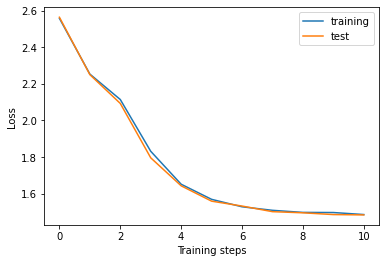

In [11]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.

plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

Finally: The Accuracy

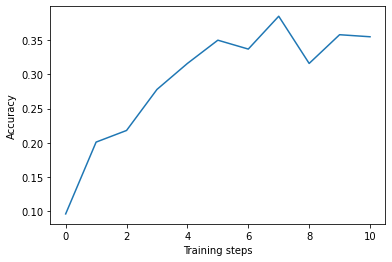

In [12]:
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()